# Perform VoI calculation using GP surrogate over join action-uncertainty space

In [1]:
import os
import json
import time
import numpy as np
from tqdm import tqdm

from scipy.stats import qmc
import sklearn.gaussian_process as gp
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib.tri as tri

import inspect
from multiprocessing import Pool

In [2]:
ids = [48]

In [3]:
# Define base parameters.
dataset_dir = os.path.join('data','A37_analysis_test') # dataset directory
opex_factor = 10
pricing_dict = {'carbon':5e-1,'battery':1e3,'solar':2e3}
with open(os.path.join(dataset_dir,'metadata_ext.json'),'r') as json_file:
        annex_defaults = json.load(json_file)
base_kwargs = {
    'output_dir_path': dataset_dir,
    'building_names': ['UCam_Building_%s'%id for id in ids],
    'battery_energy_capacities': None,
    'battery_power_capacities': [annex_defaults["building_attributes"]["battery_power_capacities (kW)"][str(id)] for id in ids],
    'battery_efficiencies': None,
    'pv_power_capacities': None,
    'load_data_paths': ['UCam_Building_%s.csv'%id for id in ids],
    'weather_data_path': 'weather.csv',
    'carbon_intensity_data_path': 'carbon_intensity.csv',
    'pricing_data_path': 'pricing.csv',
    'schema_name': 'schema_temp'
}

In [4]:
# Define multiprocessing helper functions.

n_processes = min(25,os.cpu_count()//2) # for some reason more than this is an issue ...? Maybe a memory issue

def multi_proc_constr_and_eval_system(args_list):

    from sys_eval import construct_and_evaluate_system

    return construct_and_evaluate_system(*args_list)

def parallel_task(func, iterable, n_procs):
    # Adapted from solution to https://stackoverflow.com/questions/47313732/jupyter-notebook-never-finishes-processing-using-multiprocessing-python-3/47374811
    # NOTE: this function must be in the notebook
    # NOTE: in this workaround, the function passed to `parallel_task`
    # must do all of the importing it needs, and unwrap the arguments
    # (only a single argument can be passed)

    temp_path = f'./tmp_func.py'
    with open(temp_path, 'w') as file:
        file.write(inspect.getsource(func).replace(func.__name__, "task"))

    from tmp_func import task

    if __name__ == '__main__':
        pool = Pool(processes=n_procs)
        res = list(tqdm(pool.imap(task, iterable), total=len(iterable)))
        pool.close()
        os.remove(temp_path)
        return res
    else:
        raise "Not in Jupyter Notebook"

## Step 1: Train GP Surrogate

Note: probably sensible to conduct an initial rough space search to identify sensible bounds as we expect the objective (cost) to be behaviour reasonably nicely, at least far from the region of the optimum.
The smaller the bounded region the better the surrogate will be and the easier the global optimisation will be - however as these bounds are arbitrary, if we encounter boundary solutions, the bounds need to be extended.

Remeber to note Dom's alternative suggestion for learning a surrogate, and it's motivation from the smoothness of his posterior solution results

In [5]:
# Perform sampling of action-uncertainty space
seed = 42
n_samples = 5000 # increase for final results?

# Space filling sampling of action sub-space using Latin Hypercube
lower_bounds = np.array([*[1.2e2]*len(ids),*[8e2]*len(ids)])
upper_bounds = np.array([*[1.6e3]*len(ids),*[1.2e3]*len(ids)])

action_sampler = qmc.LatinHypercube(d=len(ids)*2)
action_samples = action_sampler.random(n=n_samples)
action_samples = qmc.scale(action_samples, lower_bounds, upper_bounds)

# Sample from prior distributions of uncertain parameters
mu = 0.85
sigma = 0.1
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_samples,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

# Combine samples from two sub-spaces
space_samples = np.hstack([action_samples,eta_samples])

In [6]:
# Evaluate system cost over samples. (Old serial implementation)
# costs = []
# for n in tqdm(range(n_samples)):
#     cost = construct_and_evaluate_system(action_samples[n][:len(ids)],action_samples[n][len(ids):],eta_samples[n],base_kwargs,pricing_dict,opex_factor)
#     costs.append(cost)

In [7]:
# Evaluate system cost over samples. (Parallelised)
mproc_args_list = [[action_samples[n][:len(ids)],action_samples[n][len(ids):],eta_samples[n],base_kwargs,pricing_dict,opex_factor,n] for n in range(n_samples)]
space_sample_costs = parallel_task(multi_proc_constr_and_eval_system, mproc_args_list, n_procs=n_processes)

100%|██████████| 1000/1000 [1:05:25<00:00,  3.93s/it]


### GP training

In [31]:
# Train Gaussian Process surrogate.

length_scale_init_guess = [*[50]*len(ids),*[40]*len(ids),*[0.1]*len(ids)]
kernel = 1 * gp.kernels.RBF(length_scale=np.array(length_scale_init_guess))
gp_surrogate = gp.GaussianProcessRegressor(kernel=kernel,normalize_y=True, n_restarts_optimizer=5)
gp_surrogate.fit(space_samples, space_sample_costs)
gp_surrogate.kernel_

0.62**2 * RBF(length_scale=[61.4, 62.6, 0.0863])

NOTE!!! Training the GP properly seems to be a bit of an issue - the length scales that comes out of the optimiser are sometimes completely off - having a good initialisation to the optimisation seems important

In [32]:
mean_prediction, std_prediction = gp_surrogate.predict(space_samples, return_std=True)

In [33]:
# Visual surrogate model.

# Create set of points in action sub-space to interpolate to
n_predict_points = 1000
action_predict_sampler = qmc.LatinHypercube(d=len(ids)*2)
action_predict_samples = action_predict_sampler.random(n=n_predict_points)
action_predict_samples = qmc.scale(action_predict_samples, lower_bounds, upper_bounds)

# Compute mean cost predicted by surrogate model.
cost_predictions = []

n_MC_samples = 1000
for sample in tqdm(action_predict_samples):
    eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_MC_samples,len(ids)))
    eta_samples = np.clip(eta_samples,0,1)
    predict_points = np.hstack([np.tile(sample,(n_MC_samples,1)),eta_samples])
    mean_prediction = gp_surrogate.predict(predict_points)
    cost_predictions.append(np.mean(mean_prediction))

100%|██████████| 1000/1000 [00:36<00:00, 27.13it/s]


(500.0, 900.0)

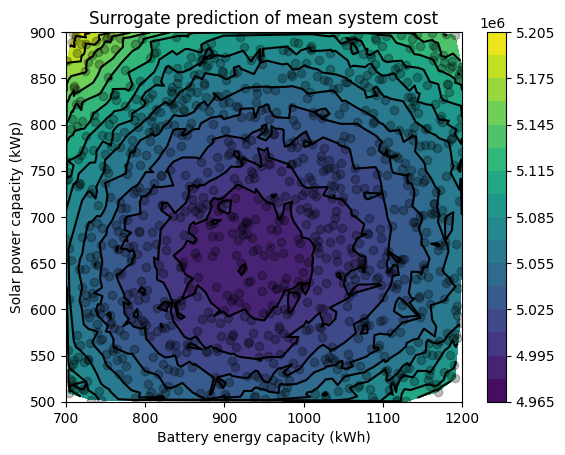

In [34]:
# Plot estatimate mean cost prediction from surrogate.
assert len(ids) == 1

n_levels = 20

fig, ax = plt.subplots()
triang = tri.Triangulation(action_predict_samples[:,0],action_predict_samples[:,1])
tcf = ax.tricontourf(triang,cost_predictions,levels=n_levels)
ax.tricontour(triang, cost_predictions,levels=n_levels, colors='k')
ax.plot(action_predict_samples[:,0],action_predict_samples[:,1],'ko',alpha=0.25)
fig.colorbar(tcf)
ax.set_title("Surrogate prediction of mean system cost")
ax.set_xlabel("Battery energy capacity (kWh)")
ax.set_ylabel("Solar power capacity (kWp)")
ax.set_xlim(lower_bounds[0],upper_bounds[0])
ax.set_ylim(lower_bounds[1],upper_bounds[1])

The lumpier the objective near the true optimum, the worse job the surrogate will do in accurately representing the optimisation. However, this is a feature of the difficultness of the problem, as the global optimisation of the direct MC estimate will also struggle (i.e. require more fevals). The way we deal with this is by adding more sample points to the GP.

Potentially a smarter strategy is to use a mutil-fidelity modelling approach, and refine the bounds on the sampled points iteratively to the subdomain in which the optimal values lie (for likely samples of the uncertain variables), as only this reigon contributes to the computed VoI value.

100%|██████████| 1000/1000 [00:00<00:00, 2628.43it/s]

[0.9265557]


(500.0, 900.0)

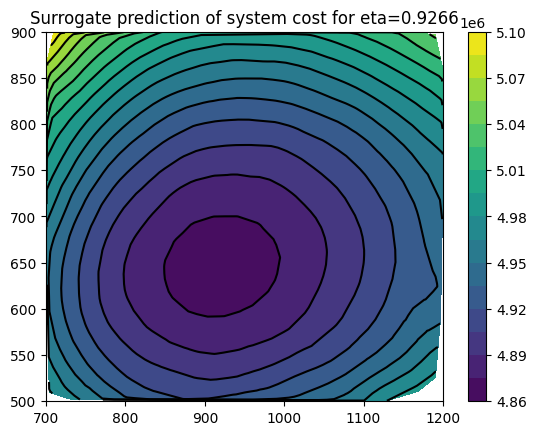

In [35]:
# Compute cost predicted by surrogate model for specific eta.
se_cost_predictions = []
eta_sample = np.random.normal(loc=mu,scale=sigma,size=(len(ids)))
eta_sample = np.clip(eta_sample,0,1)

for sample in tqdm(action_predict_samples):
    predict_points = np.hstack([sample,eta_sample])
    mean_prediction = gp_surrogate.predict([predict_points])
    se_cost_predictions.append(np.mean(mean_prediction))

print(eta_sample)

# Plot estatimate mean cost prediction from surrogate.
assert len(ids) == 1

n_levels = 20

fig, ax = plt.subplots()
triang = tri.Triangulation(action_predict_samples[:,0],action_predict_samples[:,1])
tcf = ax.tricontourf(triang,se_cost_predictions,levels=n_levels)
ax.tricontour(triang, se_cost_predictions,levels=n_levels, colors='k')
fig.colorbar(tcf)
ax.set_title(f"Surrogate prediction of system cost for eta=%s"%round(eta_sample[0],4))
ax.set_xlim(lower_bounds[0],upper_bounds[0])
ax.set_ylim(lower_bounds[1],upper_bounds[1])

### Investigate convergence of MC estimate using surrogate model

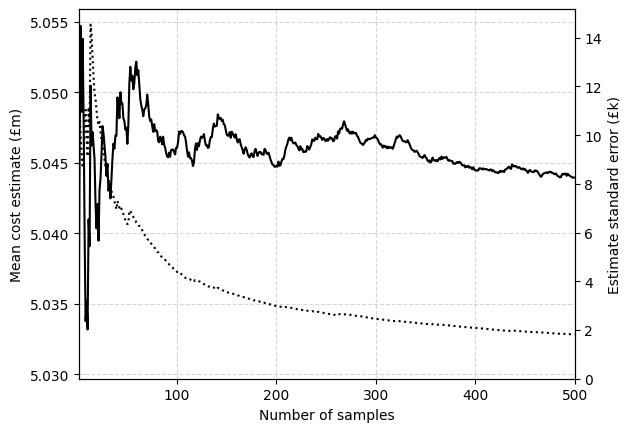

In [36]:
# use last cost_predictions as test case
n_draws = 1000

MC_means = [np.mean(cost_predictions[:i]) for i in range(1,n_draws+1)]
MC_stnd_errors = [np.std(cost_predictions[:i])/np.sqrt(i) for i in range(2,n_draws+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_draws)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_draws+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Mean cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_draws+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)

plt.show()

## Step 2: Solve Prior Problem using Surrogate

In [37]:
# Define fn of mean system cost predicted by surrogate.
def mean_cost_surrogate_estimate(x, surrogate, n_MC_samples, eta_mu, eta_sigma):

    assert len(x) % 2 == 0, "Design variable argument must have even length."

    # Make draw from distribution of uncertainties - specified in args (mu, sigma)
    # ========================================================================
    eta_samples = np.random.normal(loc=eta_mu,scale=eta_sigma,size=(n_MC_samples,len(ids)))
    eta_samples = np.clip(eta_samples,0,1)

    # Predict costs for each efficiency sample at target point using surrogate
    # ========================================================================
    predict_points = np.hstack([np.tile(x,(n_MC_samples,1)),eta_samples])
    mean_prediction = surrogate.predict(predict_points)

    return np.mean(mean_prediction)

In [38]:
bounds = op.Bounds(lb=lower_bounds,ub=upper_bounds)
n_surrogate_MC_samples = 1000

In [39]:
prior_soln = op.differential_evolution(mean_cost_surrogate_estimate, bounds, args=(gp_surrogate,n_surrogate_MC_samples,mu,sigma), seed=seed)
print(prior_soln.x, prior_soln.fun, prior_soln.nfev, prior_soln.message)
prior_design = prior_soln.x
prior_cost = prior_soln.fun
print(f"Predicted prior solution cost: {round(prior_cost,2)}")

[907.6011664  666.14734932] 4978461.359050576 132 Optimization terminated successfully.
4978461.359050576


### Test quality of surrogate prior optimal solution

In [40]:
n_MC_samples = 100
eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_MC_samples,len(ids)))
eta_samples = np.clip(eta_samples,0,1)

# sample_costs = []
# for eta_sample in tqdm(eta_samples):
#     sample_cost = construct_and_evaluate_system(prior_design[:len(ids)],prior_design[len(ids):],eta_sample,base_kwargs,pricing_dict,opex_factor)
#     sample_costs.append(sample_cost)
mproc_args_list = [[prior_design[:len(ids)],prior_design[len(ids):],eta_samples[n],base_kwargs,pricing_dict,opex_factor,n] for n in range(n_MC_samples)]
sample_costs = parallel_task(multi_proc_constr_and_eval_system, mproc_args_list, n_procs=n_processes)

true_prior_soln_cost_estimate = np.mean(sample_costs)

print(f"True prior solution cost: {round(true_prior_soln_cost_estimate,2)}")
print(f"Surrogate prior optimal solution fn error: {round(np.abs(true_prior_soln_cost_estimate-prior_cost),2)},\
    {round((np.abs(true_prior_soln_cost_estimate-prior_cost)/true_prior_soln_cost_estimate)*100,2)}%")

100%|██████████| 100/100 [07:18<00:00,  4.39s/it] 

Surrogate prior optimal solution fn error: 11662.73,    0.23%


Compare absolute error to MC estimate standard error

In [41]:
print(np.std(sample_costs)/np.sqrt(len(sample_costs)))

13863.138709146358


## Step 3: Solve Pre-Posterior Problem using Surrogate

In [42]:
# Sample from prior distribution of uncertainties.
n_prior_samples = 500
prior_eta_samples = np.random.normal(loc=mu,scale=sigma,size=(n_prior_samples,len(ids)))
prior_eta_samples = np.clip(prior_eta_samples,0,1)

In [43]:
posterior_sigma = 0.01 # define measurment uncertainty

posterior_optimal_results = []
prior_soln_performances = []

# Solve posterior problem for each eta sample.
for eta_sample in tqdm(prior_eta_samples):
    posterior_soln = op.differential_evolution(mean_cost_surrogate_estimate, bounds, args=(gp_surrogate,n_surrogate_MC_samples,eta_sample,posterior_sigma), seed=seed)
    posterior_optimal_results.append(posterior_soln)
    #print(eta_sample, posterior_soln.x, posterior_soln.fun, posterior_soln.message)

    # check surrogate predicted performance (cost) of prior solution for posterior given sampled eta value
    prior_soln_eta_cost = mean_cost_surrogate_estimate(prior_design,gp_surrogate,n_surrogate_MC_samples,eta_sample,posterior_sigma)
    prior_soln_performances.append(prior_soln_eta_cost)

100%|██████████| 100/100 [08:11<00:00,  4.92s/it]


In [44]:
preposterior_costs = [res.fun for res in posterior_optimal_results]
preposterior_cost = np.mean(preposterior_costs)
print("Pre-posterior cost: %s"%preposterior_cost)
print("Prior cost check: ",np.mean(prior_soln_performances),prior_cost)

Pre-posterior cost: 5001059.84469519
Prior cost check:  5002132.977155897 4978461.359050576


NOTE: The two methods of calculating prior solution cost return quite different values - which one is better to use? Potentially the one computed using the nested expectations as it uses the same posterior cost curve estimates (from the surrogate) that is used for the posterior optimisation. But on the other hand, the first method is one used to determine the prior solution.

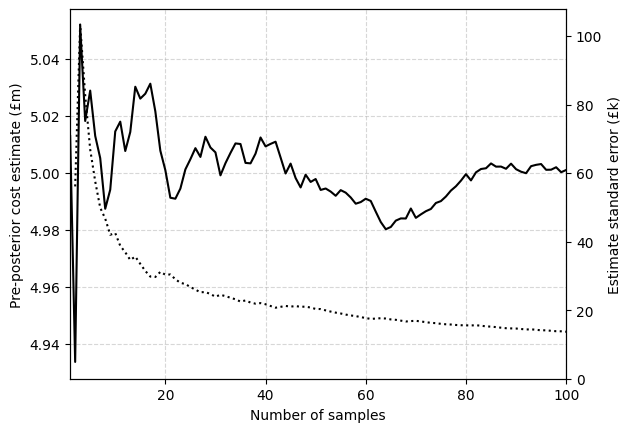

In [45]:
# Plot convergence of pre-posterior cost MC estimate.

MC_means = [np.mean(preposterior_costs[:i]) for i in range(1,n_prior_samples+1)]
MC_stnd_errors = [np.std(preposterior_costs[:i])/np.sqrt(i) for i in range(2,n_prior_samples+1)]

fig,ax = plt.subplots()
ax.set_xlim(1,n_prior_samples)
ax.set_xlabel("Number of samples")
ax.grid(True,'major',alpha=0.5,linestyle='--')

ax.plot(range(1,n_prior_samples+1),np.array(MC_means)/1e6,'-k')
ax.set_ylabel('Pre-posterior cost estimate (£m)')
#ax.set_ylim(0)

# min_ax = ax.twinx()
# min_ax.plot(range(2,n_draws+1),(np.array(MC_stnd_errors)/MC_means[-1])*100,'k--')
# min_ax.set_ylabel('Estimate standard error (% of final mean)')
# min_ax.set_ylim(0)

min_ax_abs = ax.twinx()
min_ax_abs.plot(range(2,n_prior_samples+1),np.array(MC_stnd_errors)/1e3,'k:')
min_ax_abs.set_ylabel('Estimate standard error (£k)')
min_ax_abs.set_ylim(0)

plt.show()

C:\Users\mal84\AppData\Local\Temp\ipykernel_49180\3071879592.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap()
C:\Users\mal84\AppData\Local\Temp\ipykernel_49180\3071879592.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


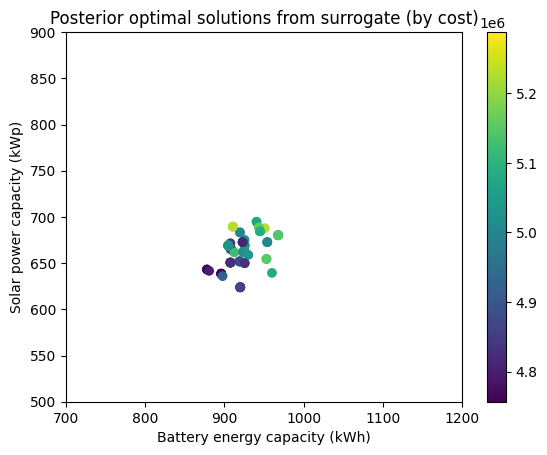

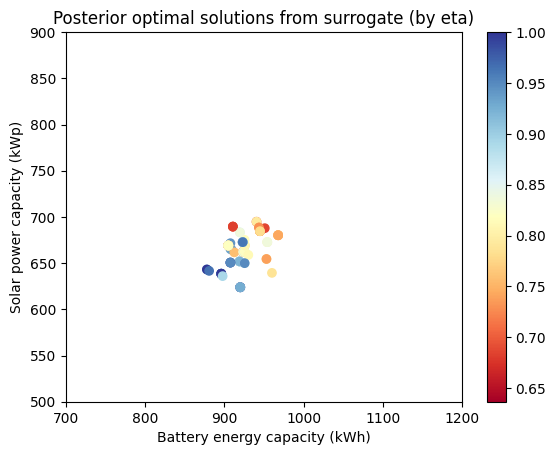

In [46]:
# Plot map of posterior optimal solutions.
assert len(ids) == 1

posterior_optimal_solutions = np.array([res.x for res in posterior_optimal_results])

fig, ax = plt.subplots()
cm = plt.cm.get_cmap()
sc = plt.scatter(posterior_optimal_solutions[:,0], posterior_optimal_solutions[:,1], c=preposterior_costs,cmap=cm)
#plt.scatter(prior_design[0],prior_design[1],c='k')
ax.set_title("Posterior optimal solutions from surrogate (by cost)")
ax.set_xlabel("Battery energy capacity (kWh)")
ax.set_ylabel("Solar power capacity (kWp)")
ax.set_xlim(lower_bounds[0],upper_bounds[0])
ax.set_ylim(lower_bounds[1],upper_bounds[1])
plt.colorbar(sc)
#plt.show()

fig, ax = plt.subplots()
cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(posterior_optimal_solutions[:,0], posterior_optimal_solutions[:,1], c=prior_eta_samples,cmap=cm)
#plt.scatter(prior_design[0],prior_design[1],c='k')
ax.set_title("Posterior optimal solutions from surrogate (by eta)")
ax.set_xlabel("Battery energy capacity (kWh)")
ax.set_ylabel("Solar power capacity (kWp)")
ax.set_xlim(lower_bounds[0],upper_bounds[0])
ax.set_ylim(lower_bounds[1],upper_bounds[1])
plt.colorbar(sc)
#plt.show()

These would be really great plots to use to iterate the state-space bounds!!!

### Test quality of surrogate posterior optimal solutions

Note - this calculation is extremely hefty! However, we can use a random sub-sample of solutions to estimate mean quality (note solutions are already randomly ordered)

In [51]:
n_MC_samples = 100
n_solns_used = 100

true_posterior_soln_cost_estimates = []

# Compute direct MC estimate of optimal solution cost for each eta sample.
for i, (posterior_result,eta_sample) in tqdm(enumerate(zip(posterior_optimal_results,prior_eta_samples)),total=n_solns_used):
    if i < n_solns_used:
        posterior_eta_samples = np.random.normal(loc=eta_sample,scale=posterior_sigma,size=(n_MC_samples,len(ids)))
        posterior_eta_samples = np.clip(posterior_eta_samples,0,1)
        mproc_args_list = [[posterior_result.x[:len(ids)],posterior_result.x[len(ids):],posterior_eta_samples[n],base_kwargs,pricing_dict,opex_factor,n] for n in range(n_MC_samples)]
        posterior_sample_costs = parallel_task(multi_proc_constr_and_eval_system, mproc_args_list, n_procs=n_processes)
        true_posterior_soln_cost_estimates.append(np.mean(posterior_sample_costs))

100%|██████████| 50/50 [03:27<00:00,  4.15s/it]it]
100it [2:55:24, 105.25s/it]                       

Predicted posterior solution costs:  [5012999.654145497, 4854313.753138982, 5287658.108544633, 4918124.049286143, 5071596.414177302, 4933508.213357725, 4958450.711360542, 4862886.303084478, 5047735.014489849, 5198799.265382061, 5052345.921240893, 4894294.208626931, 5094701.445516471, 5236810.853898493, 4967728.102904787, 5053607.072816618, 5087686.61604458, 4856675.428465766, 4759145.389322332, 4870809.9101734795, 4797771.671456856, 4983833.979579895, 5072650.444546886, 5156529.892489296, 5090542.51388664, 5105805.799714018, 4925535.773897801, 5204049.407301615, 4903159.993395481, 4957742.189531519, 4757167.0832237, 5136153.98380089, 5121956.950253727, 5120551.177977686, 5003108.107163429, 4771306.153149293, 4997658.599223739, 5132992.633921161, 5228404.489780784, 4887357.365003727, 5044926.22616867, 5042814.339965149, 4772752.60497913, 4758122.728019847, 5155890.076147451, 4770386.831107828, 4842879.85850708, 5209925.343138858, 4874380.017910035, 5048378.462442103]
Estimates of true p

In [52]:
print("Predicted posterior solution costs: ",preposterior_costs[:n_solns_used])
print("Estimates of true posterior solution costs: ",true_posterior_soln_cost_estimates)
mean_posterior_soln_fn_error = np.mean(np.abs(np.array(true_posterior_soln_cost_estimates)-np.array(preposterior_costs[:n_solns_used])))
mean_posterior_soln_fn_error_perc = np.mean((np.abs(np.array(true_posterior_soln_cost_estimates)-np.array(preposterior_costs[:n_solns_used]))/np.array(true_posterior_soln_cost_estimates))*100)
print(f"Surrogate mean posterior optimal solution fn error: {round(mean_posterior_soln_fn_error,2)}, {round(mean_posterior_soln_fn_error_perc,2)}%")

Predicted posterior solution costs:  [5012999.654145497, 4854313.753138982, 5287658.108544633, 4918124.049286143, 5071596.414177302, 4933508.213357725, 4958450.711360542, 4862886.303084478, 5047735.014489849, 5198799.265382061, 5052345.921240893, 4894294.208626931, 5094701.445516471, 5236810.853898493, 4967728.102904787, 5053607.072816618, 5087686.61604458, 4856675.428465766, 4759145.389322332, 4870809.9101734795, 4797771.671456856, 4983833.979579895, 5072650.444546886, 5156529.892489296, 5090542.51388664, 5105805.799714018, 4925535.773897801, 5204049.407301615, 4903159.993395481, 4957742.189531519, 4757167.0832237, 5136153.98380089, 5121956.950253727, 5120551.177977686, 5003108.107163429, 4771306.153149293, 4997658.599223739, 5132992.633921161, 5228404.489780784, 4887357.365003727, 5044926.22616867, 5042814.339965149, 4772752.60497913, 4758122.728019847, 5155890.076147451, 4770386.831107828, 4842879.85850708, 5209925.343138858, 4874380.017910035, 5048378.462442103]
Estimates of true p

In [ ]:
# Graph posterior solution error results?

## Step 4: Report VOI Result

We can use the standard error on the pre-posterior cost MC estimate as an error for result reporting.

In [47]:
print("VOI: %s"%round(prior_cost-preposterior_cost,2))
print("plus-minus: %s"%round(np.std(preposterior_costs)/np.sqrt(n_prior_samples),2))

VOI: -22598.49
plus-minus: 13715.48


In [48]:
print(prior_cost,preposterior_cost)

4978461.359050576 5001059.84469519


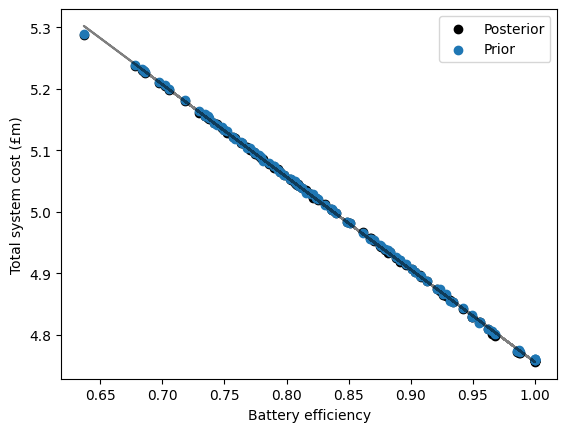

In [65]:
# Plot impact of efficiency on total system cost.
assert len(ids) == 1

trend = np.polyfit(prior_eta_samples.flatten(),preposterior_costs,deg=1)

plt.scatter(prior_eta_samples,np.array(preposterior_costs)/1e6,c='k',label='Posterior')
plt.plot(prior_eta_samples,(prior_eta_samples*trend[0] + trend[1])/1e6,'k-',alpha=0.5)
plt.scatter(prior_eta_samples,np.array(prior_soln_performances)/1e6,label='Prior')
plt.xlabel("Battery efficiency")
plt.ylabel("Total system cost (£m)")
plt.legend()

Battery efficiency has a significant impact on the system cost, but knowing it a priori does not impact the optimal system design solution significantly.

Text(0, 0.5, 'Prior solution cost sub-optimality (£k)')

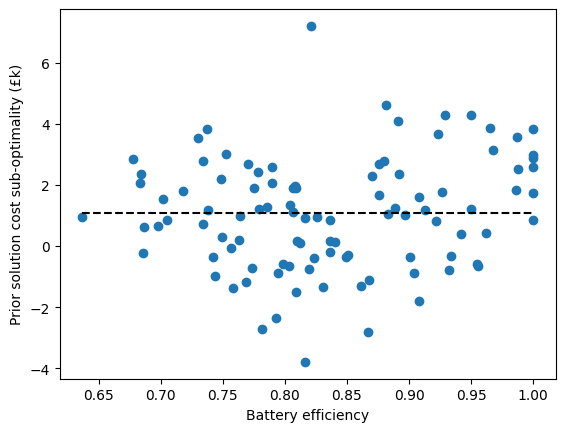

In [73]:
prior_soln_subopts = np.array(prior_soln_performances)-np.array(preposterior_costs)
plt.hlines(np.mean(prior_soln_subopts)/1e3,min(prior_eta_samples),max(prior_eta_samples),'k',ls='--')
plt.scatter(prior_eta_samples,(prior_soln_subopts)/1e3)
plt.xlabel("Battery efficiency")
plt.ylabel("Prior solution cost sub-optimality (£k)")

The instances in the which the prior solution is better than the posterior solution (negative sub-optimalities) are artefacts of the global optimisation and MC estimate errors.